### Loss plot

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
loss = pd.read_csv('model_pruned_graph_1.1.loss.csv')
loss.head()

,epoch,loss
0,1,3.263271
1,2,2.761802
2,3,2.359528
3,4,2.086520
4,5,1.806247


In [23]:
loss = loss[loss['epoch']<=1120]

Text(0.5, 1.0, 'Model Loss')

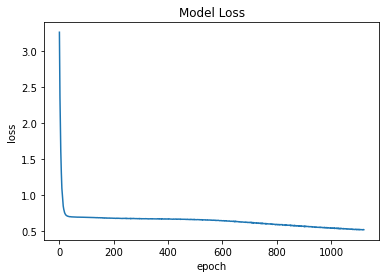

In [25]:
ax = sns.lineplot(x='epoch', y='loss', data=loss)
ax.set_title('Model Loss')

Text(0.5, 1.0, 'Model Evaluation')

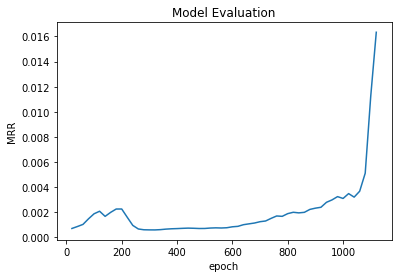

In [27]:
mrr = pd.read_csv('model_pruned_graph_1.1.mrr.csv')
mrr = mrr[mrr['epoch'] <= 1120]
ax = sns.lineplot(x='epoch', y='mrr', data=mrr)
ax.set_ylabel('MRR')
ax.set_title('Model Evaluation')

### Evaluate model

In [1]:
import utils
from model import LinkPredict
from prune import prune_graph

import torch
import numpy as np
import pandas as pd
import json

from sklearn.model_selection import train_test_split

Using backend: pytorch


In [2]:
def node_norm_to_edge_norm(g, node_norm):
    g = g.local_var()
    # convert to edge norm
    g.ndata['norm'] = node_norm
    g.apply_edges(lambda edges : {'norm' : edges.dst['norm']})
    return g.edata['norm']

In [3]:
model_path = 'model_pruned_graph_1.1.model_state_gpu.pth'

model_param = {
    'h_dim'    : 80, # output feature size
    'dropout'  : 0.2,
    'num_bases': 30,
    'num_hidden_layers': 4,
    'use_cuda' : True,
    'reg_param': 0.01
}
use_cuda = model_param['use_cuda']
if use_cuda: torch.device('cuda')

In [4]:
graph = np.load('./pruned_graph_1.npy')

# map nodes
all_nodes = sorted(list(set(graph[:,0].tolist() + graph[:,2].tolist())))
node_map = {i: node for i, node in enumerate(all_nodes)}
node_map_rev = {node: i for i, node in enumerate(all_nodes)}

# map the nodes
mapped_graph = np.zeros(graph.shape, dtype=int)
for i, row in enumerate(graph):
    mapped_graph[i] = [node_map_rev[row[0]], row[1], node_map_rev[row[2]]]

diseases_nodes = list(set(mapped_graph[np.isin(mapped_graph[:,1], [0])][:,2]))
drugs_nodes = list(set(mapped_graph[np.isin(mapped_graph[:,1], range(5))][:,0]))
print('There are %d drugs' % len(drugs_nodes))

There are 233 drugs


In [5]:
covid_node = node_map_rev[37893]
covid_test_data = np.zeros((len(drugs_nodes), 3), dtype=int)
for i in range(len(covid_test_data)):
    covid_test_data[i] = [drugs_nodes[i], 0, covid_node]

In [6]:
num_nodes = len(list(set(np.unique(mapped_graph[:,0])).union(set(np.unique(mapped_graph[:,2])))))
num_rels = np.unique(mapped_graph[:,1]).shape[0]
num_edges = mapped_graph.shape[0]

# divide drug-treat-disease associations into test, train, and validation
# initiate train data with non-treat edges (relation type: 0)
train_data = mapped_graph[mapped_graph[:,1] != 0]
full_treat_edges = mapped_graph[mapped_graph[:,1] == 0]
treat_train_data, val_data = train_test_split(full_treat_edges, test_size=0.2, random_state=0)
train_data = np.concatenate((train_data, treat_train_data), axis=0)

In [7]:
test_graph, test_rel, test_norm = utils.build_test_graph(
        num_nodes, num_rels, train_data)
test_deg = test_graph.in_degrees(range(test_graph.number_of_nodes())).float().view(-1, 1)
test_node_id = torch.arange(0, num_nodes, dtype=torch.long).view(-1, 1)
test_rel = torch.from_numpy(test_rel)
test_norm = node_norm_to_edge_norm(test_graph, torch.from_numpy(test_norm).view(-1, 1))

Test graph:
# nodes: 6605, # edges: 573583


C:\Users\sucip\OneDrive\Harvard\1_Spring2020\HST956\project\COVID19-Drug-Repurposing\model\utils.py:122: RuntimeWarning: divide by zero encountered in true_divide
  norm = 1.0 / in_deg


In [8]:
# load model
model = LinkPredict(in_dim   = num_nodes,
                    h_dim    = model_param['h_dim'],
                    num_rels = num_rels,
                    num_bases= model_param['num_bases'],
                    num_hidden_layers = model_param['num_hidden_layers'],
                    dropout  = model_param['dropout'],
                    use_cuda = model_param['use_cuda'],
                    reg_param= model_param['reg_param'])
model.load_state_dict(torch.load(model_path)['state_dict'])
model.eval()

embed = model(test_graph, test_node_id, test_rel, test_norm)

In [9]:
mrr = utils.calc_mrr(embed, model.w_relation, torch.LongTensor(train_data), [], torch.LongTensor(val_data),
                    hits=[1,10], eval_bz=500, eval_p='raw')

batch 0 / 1
batch 0 / 1
MRR (raw): 0.016338
Hits (raw) @ 1: 0.008621
Hits (raw) @ 10: 0.025862


..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [12]:
covid_test_data

array([[   0,    0, 6604],
       [   1,    0, 6604],
       [   2,    0, 6604],
       [   3,    0, 6604],
       [   4,    0, 6604],
       [   5,    0, 6604],
       [   6,    0, 6604],
       [   7,    0, 6604],
       [   8,    0, 6604],
       [   9,    0, 6604],
       [  10,    0, 6604],
       [  11,    0, 6604],
       [  12,    0, 6604],
       [  13,    0, 6604],
       [  14,    0, 6604],
       [  15,    0, 6604],
       [  16,    0, 6604],
       [  17,    0, 6604],
       [  18,    0, 6604],
       [  19,    0, 6604],
       [  20,    0, 6604],
       [  21,    0, 6604],
       [  22,    0, 6604],
       [  23,    0, 6604],
       [  24,    0, 6604],
       [  25,    0, 6604],
       [  26,    0, 6604],
       [  27,    0, 6604],
       [  28,    0, 6604],
       [  29,    0, 6604],
       [  30,    0, 6604],
       [  31,    0, 6604],
       [  32,    0, 6604],
       [  33,    0, 6604],
       [  34,    0, 6604],
       [  35,    0, 6604],
       [  36,    0, 6604],
 

In [15]:
covid_scores = model.calc_score(embed, covid_test_data).detach().numpy()
potent_drugs = [(node_map[e[0]], covid_scores[i]) for i, e in enumerate(covid_test_data)]
potent_drugs.sort(key = lambda x:x[1], reverse=True)

In [16]:
drugs = pd.read_csv('../data/clean/drugs.wse.nodes', header=None)
drug_id_name_dict = json.load(open('../data/clean/drugs-name-dict.json'))

num_drugs = drugs.shape[0]
drug_num_dict = {num: drug for (num, drug) in zip(range(num_drugs), drugs[0])}
potent_drugs = [(drug_num_dict[drug[0]], drug[1]) for drug in potent_drugs] 

In [17]:
covid_drugs = pd.read_csv('../data/clean/covid-drugs', header=None)
covid_drugs.head()

,0,1
0,DB00313,Valproic acid
1,DB12207,Verdinexor
2,DB06733,Bafilomycin A1
3,DB08912,Dabrafenib
4,DB00608,Chloroquine


In [18]:
covid_drugs_dict = {id: name for (id, name) in zip(covid_drugs[0], covid_drugs[1])}
covid_drugs_dict

{'DB00313': 'Valproic acid',
 'DB12207': 'Verdinexor',
 'DB06733': 'Bafilomycin A1',
 'DB08912': 'Dabrafenib',
 'DB00608': 'Chloroquine',
 'DB00446': 'Chloramphenicol',
 'DB00328': 'Indomethacin',
 'DB00494': 'Entacapone',
 'DB05018': 'Migalastat',
 'DB00331': 'Metformin',
 'DB07995': 'H-89',
 'DB04862': 'Merimepodib',
 'DB00560': 'Tigecycline',
 'DB00601': 'Linezolid',
 'DB00811': 'Ribavirin',
 'DB01024': 'Mycophenolic acid',
 'DB08901': 'Ponatinib',
 'DB00877': 'Rapamycin',
 'DB11836': 'Sapanisertib',
 'DB12000': 'Apabetalone',
 'DB15408': 'Silmitasertib',
 'DB00661': 'Verapamil',
 'DB00694': 'Daunorubicin',
 'DB00502': 'Haloperidol',
 'DB06595': 'Midostaurin',
 'DB08877': 'Ruxolitinib',
 'DB11759': 'Pevonedistat',
 'DB13729': 'Camostat',
 'DB12598': 'Nafamostat',
 'DB01197': 'Captoril',
 'DB00722': 'Lisinopril',
 'DB15219': 'Tomivosertib'}

In [19]:
rank = []
for i, drug in enumerate(potent_drugs[:50]):
    if drug[0] in covid_drugs_dict:
        print(i, drug[0], drug_id_name_dict[drug[0]])
    else:
        print('\t', drug[0], drug_id_name_dict[drug[0]])

	 DB01033 Mercaptopurine
	 DB01045 Rifampicin
2 DB01024 Mycophenolic acid
	 DB09213 Dexibuprofen
4 DB08901 Ponatinib
	 DB00163 Vitamin E
	 DB00688 Mycophenolate mofetil
	 DB00171 ATP
	 DB04216 Quercetin
	 DB14481 Calcium phosphate dihydrate
	 DB00977 Ethinylestradiol
	 DB00503 Ritonavir
	 DB00773 Etoposide
	 DB01232 Saquinavir
	 DB00635 Prednisone
	 DB00252 Phenytoin
	 DB01262 Decitabine
	 DB11632 Opicapone
	 DB00762 Irinotecan
	 DB02703 Fusidic acid
	 DB00541 Vincristine
	 DB06103 VX-148
	 DB04348 Taurocholic acid
	 DB04315 Guanosine-5'-Diphosphate
	 DB00166 Lipoic acid
	 DB01104 Sertraline
	 DB08881 Vemurafenib
	 DB14003 alpha-Tocopherol acetate
	 DB13783 Acemetacin
	 DB04786 Suramin
	 DB00721 Procaine
	 DB00421 Spironolactone
	 DB03478 2'-O-Acetyl Adenosine-5-Diphosphoribose
	 DB02379 Beta-D-Glucose
	 DB00255 Diethylstilbestrol
	 DB14548 Zinc sulfate, unspecified form
	 DB09061 Cannabidiol
	 DB00537 Ciprofloxacin
	 DB01593 Zinc
39 DB06595 Midostaurin
	 DB00988 Dopamine
	 DB01174 Phe